In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import unicodedata
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# Ruta base de los datasets
DATA_DIR = Path("../datasets")  # cámbialo si están en otra carpeta

# Cargar ventas y eventos
df_ventas = pd.read_csv(DATA_DIR / "ventas_normalizado.csv")
df_eventos = pd.read_csv(DATA_DIR / "eventos_productos.csv")

In [ ]:
def normalize_text(texto: str) -> str:
    """
    Deja el texto en minúsculas, sin acentos y sin espacios duplicados.
    """
    if pd.isna(texto):
        return ""
    texto = str(texto).lower().strip()
    texto = unicodedata.normalize("NFD", texto)
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")
    texto = " ".join(texto.split())
    return texto

# Asegurar tipos de fecha
df_ventas["fecha"] = pd.to_datetime(df_ventas["fecha"])
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

# Claves normalizadas de producto
df_ventas["product_key"] = df_ventas["product_name"].apply(normalize_text)
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)

# Merge left para marcar eventos por (fecha, producto)
df_eventos_reduc = df_eventos[["event", "date", "product_key"]].drop_duplicates()

df_ventas_evt = df_ventas.merge(
    df_eventos_reduc,
    left_on=["fecha", "product_key"],
    right_on=["date", "product_key"],
    how="left"
)

# hay_evento = 1 si existe un evento para ese producto en esa fecha
df_ventas_evt["hay_evento"] = df_ventas_evt["event"].notna().astype(int)

# Ya no necesitamos la columna date del merge
df_ventas_evt = df_ventas_evt.drop(columns=["date"])

df_ventas_evt.head(10)


,Unnamed: 0,fecha,product_name,category_off,ventas,precio,perecedero,en_temporada,temp_inicio_mes,temp_fin_mes,product_key,event,hay_evento
0,0,2022-12-01,nectar de durazno 1 l,juice-box,10,33.72,0.0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
1,1,2022-12-01,nectar de durazno 1 l,juice-box,10,33.72,0.0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
2,2,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
3,3,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
4,4,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
5,5,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
6,6,2022-12-01,betabel,fruits-vegetables,33,30.22,1.0,1,1.0,12.0,betabel,NaN,0
7,7,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0
8,8,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0
9,9,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0


In [ ]:
ventas = df_ventas_evt.copy()

# Calendario
ventas["anio"] = ventas["fecha"].dt.year
ventas["mes"] = ventas["fecha"].dt.month
ventas["dia"] = ventas["fecha"].dt.day
ventas["dia_semana"] = ventas["fecha"].dt.weekday
ventas["es_fin_semana"] = ventas["dia_semana"].isin([5, 6]).astype(int)

# Codificacion ciclica de mes y día de semana
ventas["mes_sin"] = np.sin(2 * np.pi * ventas["mes"] / 12)
ventas["mes_cos"] = np.cos(2 * np.pi * ventas["mes"] / 12)
ventas["dow_sin"] = np.sin(2 * np.pi * ventas["dia_semana"] / 7)
ventas["dow_cos"] = np.cos(2 * np.pi * ventas["dia_semana"] / 7)

# IDs de producto y categoría
ventas["product_id"], product_uniques = pd.factorize(ventas["product_name"])
ventas["category_id"], category_uniques = pd.factorize(ventas["category_off"])

n_products = len(product_uniques)
n_categories = len(category_uniques)
print("n_products:", n_products, "n_categories:", n_categories)

ventas = ventas.sort_values(["product_id", "fecha"])
ventas.head()


,Unnamed: 0,fecha,product_name,category_off,ventas,precio,perecedero,en_temporada,temp_inicio_mes,temp_fin_mes,...,mes,dia,dia_semana,es_fin_semana,mes_sin,mes_cos,dow_sin,dow_cos,product_id,category_id
0,0,2022-12-01,nectar de durazno 1 l,juice-box,10,33.72,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
1,1,2022-12-01,nectar de durazno 1 l,juice-box,10,33.72,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
2,2,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,1,1
3,3,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,1,1
4,4,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,1,1


In [4]:
ventas = ventas.sort_values(["product_id", "fecha"])

def crear_ventanas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea variables con información de ventas pasadas para cada producto.

    La función agrega:
    - Ventas de días anteriores (1, 7 y 14 días atrás).
    - Promedios de ventas recientes (7, 28 y 90 días),
      usando solo datos del pasado para no afectar el entrenamiento.

    Estas variables ayudan al modelo a aprender patrones
    como tendencias y comportamientos semanales o mensuales.

    Parámetros:
    df : DataFrame con columnas `product_id` y `ventas`.

    Retorna:
    El mismo DataFrame con nuevas columnas de apoyo para predicción.
    """
    df = df.copy()
    g = df.groupby("product_id")["ventas"]
    df["lag_1"] = g.shift(1)
    df["lag_7"] = g.shift(7)
    df["lag_14"] = g.shift(14)
    df["media_7"] = g.shift(1).rolling(7).mean()
    df["media_28"] = g.shift(1).rolling(28).mean()
    df["media_90"] = g.shift(1).rolling(90).mean()
    return df

ventas = crear_ventanas(ventas)

# Eliminamos filas sin historial suficiente
ventas_modelo = ventas.dropna(subset=[
    "lag_1", "lag_7", "lag_14",
    "media_7", "media_28", "media_90"
]).copy()

ventas_modelo.shape, ventas_modelo.head()


NameError: name 'ventas' is not defined

In [7]:
# Features para el modelo
features = [
    "product_id", "category_id", "perecedero",
    "precio", "en_temporada", "hay_evento",
    "anio", "mes", "dia_semana", "es_fin_semana",
    "mes_sin", "mes_cos", "dow_sin", "dow_cos",
    "lag_1", "lag_7", "lag_14", "media_7", "media_28", "media_90"
]

X = ventas_modelo[features]
y = ventas_modelo["ventas"]

# Corte temporal (puedes ajustar la fecha si quieres)
fecha_corte = pd.to_datetime("2025-06-01")

mask_train = ventas_modelo["fecha"] < fecha_corte
mask_test = ventas_modelo["fecha"] >= fecha_corte

X_train = X[mask_train]
X_test = X[mask_test]
y_train = y[mask_train]
y_test = y[mask_test]

X_train.shape, X_test.shape


((687311, 20), (140361, 20))

In [39]:
# Copias para NN
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()
y_train_nn = y_train.astype("float32").copy()
y_test_nn = y_test.astype("float32").copy()

# Asegurar que todo sea numérico
for col in X_train_nn.columns:
    X_train_nn[col] = pd.to_numeric(X_train_nn[col], errors="coerce")
    X_test_nn[col] = pd.to_numeric(X_test_nn[col], errors="coerce")

# Convertir a float32
X_train_nn = X_train_nn.astype("float32")
X_test_nn = X_test_nn.astype("float32")

# Filtrar filas con NaN o infinitos
mask_train_clean = np.isfinite(X_train_nn.to_numpy()).all(axis=1) & np.isfinite(y_train_nn.to_numpy())
mask_test_clean = np.isfinite(X_test_nn.to_numpy()).all(axis=1) & np.isfinite(y_test_nn.to_numpy())

X_train_nn = X_train_nn[mask_train_clean]
y_train_nn = y_train_nn[mask_train_clean]
X_test_nn = X_test_nn[mask_test_clean]
y_test_nn = y_test_nn[mask_test_clean]

print("Shapes limpias:", X_train_nn.shape, X_test_nn.shape)


Shapes limpias: (687311, 20) (140361, 20)


In [40]:
# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)
X_test_scaled = scaler.transform(X_test_nn)

X_train_scaled.shape, X_test_scaled.shape


((687311, 20), (140361, 20))

In [10]:
def big_error_loss(y_true, y_pred):
    """
    Penaliza más fuerte los errores grandes.
    - Umbral configurable (threshold)
    - Si el error absoluto > threshold, se multiplica la penalización.
    """
    err = tf.abs(y_true - y_pred)
    mse = tf.square(err)
    
    threshold = 5.0     # puedes tunear este valor
    factor_grande = 5.0 # cuánto más castigar los errores grandes
    
    weights = tf.where(err > threshold, factor_grande, 1.0)
    weighted_mse = mse * weights
    return tf.reduce_mean(weighted_mse)

input_dim = X_train_scaled.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1)   # regresión
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=big_error_loss,
    metrics=["mae"]
)

model.summary()

2025-12-05 14:23:08.311416: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_nn,
    validation_data=(X_test_scaled, y_test_nn),
    epochs=200,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 162.0763 - mae: 2.9839 - val_loss: 161.9151 - val_mae: 3.0138
Epoch 2/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 160.9366 - mae: 2.9643 - val_loss: 161.1388 - val_mae: 3.0511
Epoch 3/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 160.2445 - mae: 2.9572 - val_loss: 160.1725 - val_mae: 2.9648
Epoch 4/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 161.5916 - mae: 2.9496 - val_loss: 160.0699 - val_mae: 3.0221
Epoch 5/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 159.1267 - mae: 2.9373 - val_loss: 165.3700 - val_mae: 3.0216
Epoch 6/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 158.7818 - mae: 2.9295 - val_loss: 158.8461 - val_mae: 3.0634
Epoch 7/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 157.4212 - mae: 2.9146 - val_loss: 164.7074 - val_mae: 3.0359
Epoch 8/200
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 155.9851 - mae: 2.9058 - val_loss: 158.9136 - val_mae: 2.9910
Epoch 9/200
672/

In [13]:
# Predicciones
y_pred_nn = model.predict(X_test_scaled).ravel()

mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
mape_nn = mean_absolute_percentage_error(y_test_nn, y_pred_nn)

print("Neural Network MAE:", mae_nn)
print("Neural Network MAPE:", mape_nn)


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Neural Network MAE: 3.0634407997131348
Neural Network MAPE: 638452525694976.0


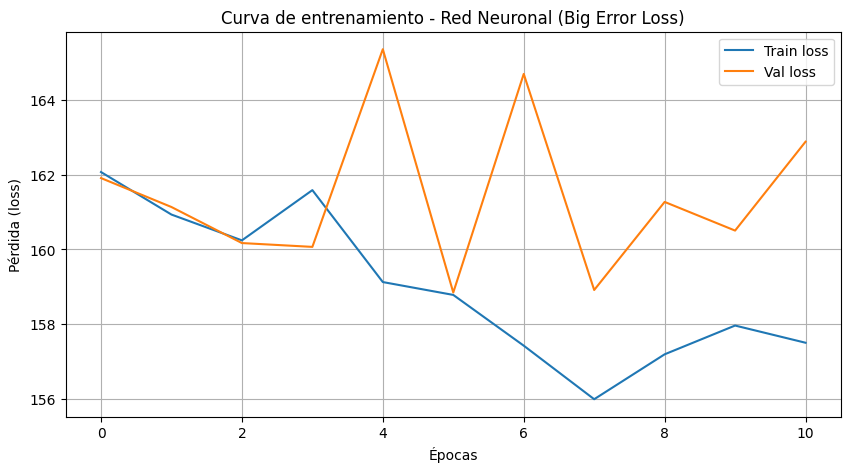

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (loss)")
plt.title("Curva de entrenamiento - Red Neuronal (Big Error Loss)")
plt.legend()
plt.grid(True)
plt.show()


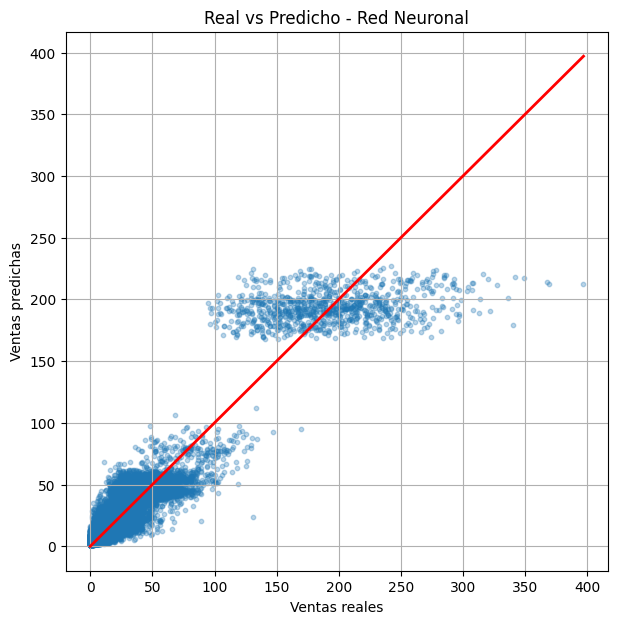

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(y_test_nn, y_pred_nn, alpha=0.3, s=10)
max_val = max(y_test_nn.max(), y_pred_nn.max())
plt.plot([0, max_val], [0, max_val], color="red", linewidth=2)
plt.xlabel("Ventas reales")
plt.ylabel("Ventas predichas")
plt.title("Real vs Predicho - Red Neuronal")
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


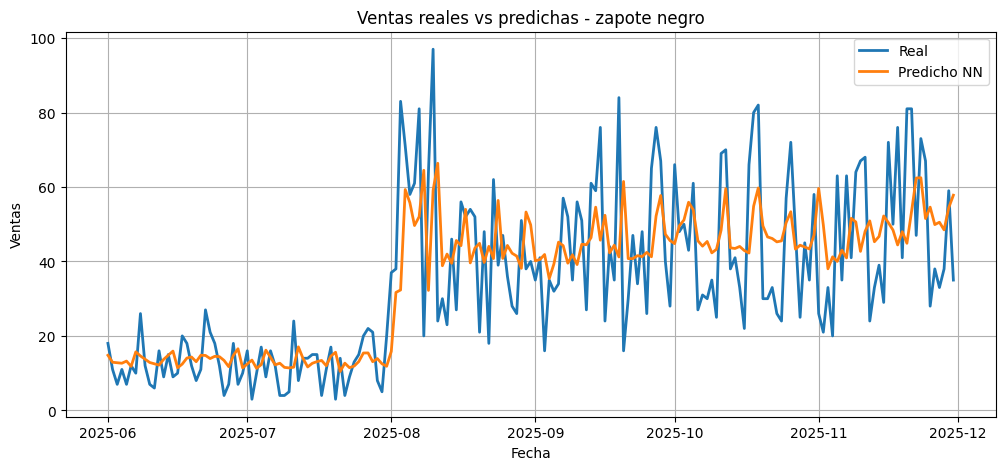

In [17]:
nombre_producto = "zapote negro"

# Obtenemos el product_id correspondiente
pid = ventas_modelo.loc[
    ventas_modelo["product_name"] == nombre_producto, "product_id"
].iloc[0]

# Creamos máscara de test solo para ese producto
mask_prod_test = (ventas_modelo["product_id"] == pid) & (ventas_modelo["fecha"] >= fecha_corte)

# Alinear índices con X_test_nn / y_test_nn
indices_test = X_test_nn.index
indices_prod_test = indices_test[mask_prod_test.loc[indices_test]]

fechas_prod = ventas_modelo.loc[indices_prod_test, "fecha"]
y_real_prod = y_test_nn.loc[indices_prod_test]
X_prod_scaled = X_test_scaled[indices_test.get_indexer(indices_prod_test)]
y_pred_prod = model.predict(X_prod_scaled).ravel()

plt.figure(figsize=(12,5))
plt.plot(fechas_prod, y_real_prod, label="Real", linewidth=2)
plt.plot(fechas_prod, y_pred_prod, label="Predicho NN", linewidth=2)
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title(f"Ventas reales vs predichas - {nombre_producto}")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
#Asegurar que df_eventos tenga clave normalizada
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

def hay_evento_en_fecha(nombre_producto: str, fecha: pd.Timestamp) -> int:
    """
    Regresa 1 si ese producto tiene un evento exactamente en esa fecha, 0 en caso contrario.
    """
    pkey = normalize_text(nombre_producto)
    eventos_prod = df_eventos[df_eventos["product_key"] == pkey]
    if eventos_prod.empty:
        return 0
    return int(fecha.normalize() in eventos_prod["date"].dt.normalize().values)


In [31]:
from datetime import timedelta, datetime

def predecir_proximos_dias(nombre_producto: str, dias: int = 7) -> pd.DataFrame:
    """
    Predice las ventas de los próximos 'dias' días para un producto específico
    usando el modelo de red neuronal entrenado.
    
    Usa:
      - ventas_modelo (histórico con lags ya calculados)
      - model (red neuronal)
      - scaler (StandardScaler)
      - features (lista de columnas de entrada)
      - df_eventos (para hay_evento)
    """
    # 1. Obtener el product_id y el histórico de ese producto
    df_prod_hist = ventas_modelo[ventas_modelo["product_name"] == nombre_producto].copy()
    if df_prod_hist.empty:
        raise ValueError(f"No se encontró histórico para el producto: {nombre_producto}")
    
    df_prod_hist = df_prod_hist.sort_values("fecha")
    
    # Información estática del producto (tomamos la última fila)
    last_row = df_prod_hist.iloc[-1]
    product_id = int(last_row["product_id"])
    category_id = int(last_row["category_id"])
    perecedero = int(last_row["perecedero"])
    precio_ultimo = float(last_row["precio"])
    
    # Para lags y medias necesitamos la serie histórica de ventas
    hist_fechas = list(df_prod_hist["fecha"])
    hist_ventas = list(df_prod_hist["ventas"].astype(float))
    
    # 2. Fecha inicial para predicciones: día siguiente del último dato
    fecha_actual = df_prod_hist["fecha"].max()
    

    # Lista donde vamos acumulando resultados
    pred_rows = []
    
    for i in range(dias):
        fecha_pred = fecha_actual + timedelta(days=1)
        
        # --- Calendario ---
        anio = fecha_pred.year
        mes = fecha_pred.month
        dia_semana = fecha_pred.weekday()   # 0 lunes, 6 domingo
        es_fin_semana = 1 if dia_semana in [5, 6] else 0
        
        mes_sin = np.sin(2 * np.pi * mes / 12)
        mes_cos = np.cos(2 * np.pi * mes / 12)
        dow_sin = np.sin(2 * np.pi * dia_semana / 7)
        dow_cos = np.cos(2 * np.pi * dia_semana / 7)
        
        # --- Eventos y flags ---
        hay_evento = hay_evento_en_fecha(nombre_producto, fecha_pred)
        
        # Para simplificar: asumimos mismo patrón de promo y temporada que el último día
        en_temporada = int(last_row["en_temporada"])
        
        # --- Lags y medias basados en hist_ventas (que vamos actualizando) ---
        # Si el histórico es corto, usamos lo que haya
        lag_1 = hist_ventas[-1]
        lag_7 = hist_ventas[-7] if len(hist_ventas) >= 7 else hist_ventas[0]
        lag_14 = hist_ventas[-14] if len(hist_ventas) >= 14 else hist_ventas[0]
        
        media_7 = float(np.mean(hist_ventas[-7:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_28 = float(np.mean(hist_ventas[-28:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_90 = float(np.mean(hist_ventas[-90:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        
        # --- Armar vector de features en el mismo orden que 'features' ---
        feature_dict = {
            "product_id": product_id,
            "category_id": category_id,
            "perecedero": perecedero,
            "precio": precio_ultimo,          # podrías dinamizar esto futuramente
            "en_temporada": en_temporada,
            "hay_evento": hay_evento,
            "anio": anio,
            "mes": mes,
            "dia_semana": dia_semana,
            "es_fin_semana": es_fin_semana,
            "mes_sin": mes_sin,
            "mes_cos": mes_cos,
            "dow_sin": dow_sin,
            "dow_cos": dow_cos,
            "lag_1": lag_1,
            "lag_7": lag_7,
            "lag_14": lag_14,
            "media_7": media_7,
            "media_28": media_28,
            "media_90": media_90,
        }
        
        # Convertir a DataFrame para pasar por el scaler
        X_fut = pd.DataFrame([feature_dict])[features].astype("float32")
        X_fut_scaled = scaler.transform(X_fut)
        
        # Predicción con el modelo
        y_pred = float(model.predict(X_fut_scaled, verbose=0).ravel()[0])
        
        # Guardar resultado
        pred_rows.append({
            "fecha": fecha_pred,
            "product_name": nombre_producto,
            "prediccion_ventas": max(y_pred, 0.0),  # evitar negativos
            "hay_evento": hay_evento,
            "en_temporada": en_temporada
        })
        
        # Actualizar histórico para el siguiente día (usamos la predicción como nueva venta)
        hist_fechas.append(fecha_pred)
        hist_ventas.append(max(y_pred, 0.0))
        
        # Avanzar fecha
        fecha_actual = fecha_pred
    
    df_pred = pd.DataFrame(pred_rows)
    return df_pred


       fecha   product_name  prediccion_ventas  hay_evento  en_temporada
0 2025-12-01  aguacate hass          18.395493           0             0
1 2025-12-02  aguacate hass          17.412617           0             0
2 2025-12-03  aguacate hass          17.204742           0             0
3 2025-12-04  aguacate hass          18.102985           0             0
4 2025-12-05  aguacate hass          18.099709           0             0
5 2025-12-06  aguacate hass          20.776814           0             0
6 2025-12-07  aguacate hass          20.620871           0             0


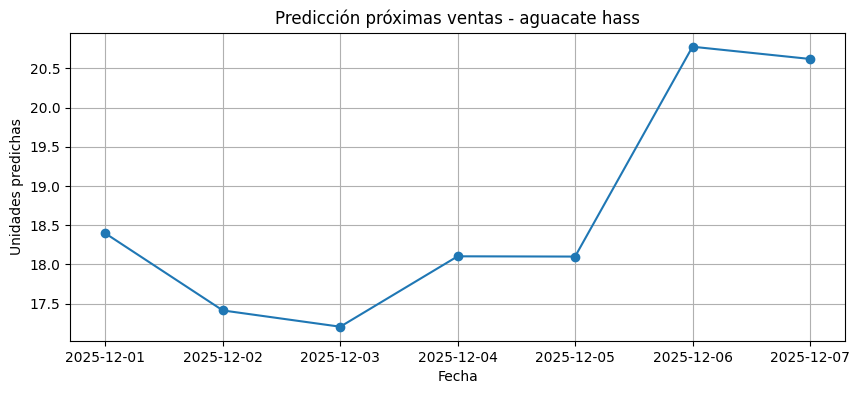

In [32]:
nombre_producto = "aguacate hass"

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=7)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


        fecha   product_name  prediccion_ventas  hay_evento  en_temporada
0  2025-12-01  aguacate hass          18.395493           0             0
1  2025-12-02  aguacate hass          17.412617           0             0
2  2025-12-03  aguacate hass          17.204742           0             0
3  2025-12-04  aguacate hass          18.102985           0             0
4  2025-12-05  aguacate hass          18.099709           0             0
5  2025-12-06  aguacate hass          20.776814           0             0
6  2025-12-07  aguacate hass          20.620871           0             0
7  2025-12-08  aguacate hass          19.930517           1             0
8  2025-12-09  aguacate hass          16.314421           0             0
9  2025-12-10  aguacate hass          16.034986           0             0
10 2025-12-11  aguacate hass          16.813072           0             0
11 2025-12-12  aguacate hass          21.870621           1             0


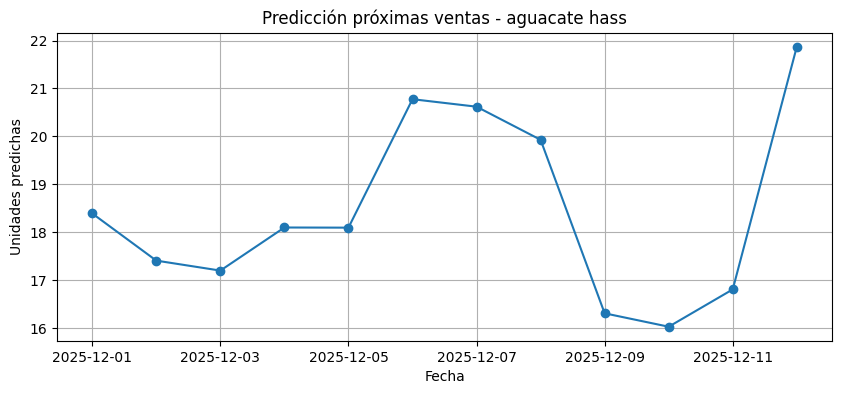

In [34]:
nombre_producto = "aguacate hass"  # cámbialo a uno que exista en tu dataset

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=12)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


In [35]:
import numpy as np

def sugerir_stock(nombre_producto: str,
                  dias: int = 7,
                  factor_seguridad: float = 1.2):
    """
    Calcula la cantidad de stock sugerido para un producto en un horizonte de 'dias',
    usando el modelo de predicción + un factor de seguridad.

    Parámetros:
    -----------
    nombre_producto : str
        Nombre EXACTO del producto tal como aparece en ventas_modelo["product_name"].
    dias : int, opcional (default=7)
        Número de días a futuro que se quieren cubrir con el stock.
    factor_seguridad : float, opcional (default=1.2)
        Factor multiplicador para protegerte ante errores del modelo y variaciones
        inesperadas en la demanda.
        Ejemplo: 1.2 = 20% extra de colchón.

    Regresa:
    --------
    df_pred : pandas.DataFrame
        Tabla con la predicción diaria:
        [fecha, product_name, prediccion_ventas, hay_evento, en_promocion, en_temporada]
    demanda_esperada : float
        Suma de las unidades esperadas a vender en esos 'dias'.
    stock_sugerido : float
        Unidades recomendadas de stock (demanda_esperada * factor_seguridad).
        Se redondea hacia arriba.
    """
    # 1. Obtener predicciones diarias
    df_pred = predecir_proximos_dias(nombre_producto, dias=dias)

    # 2. Demanda esperada total (suma de las predicciones diarias)
    demanda_esperada = df_pred["prediccion_ventas"].sum()

    # 3. Aplicar factor de seguridad
    stock_sugerido = np.ceil(demanda_esperada * factor_seguridad)

    return df_pred, demanda_esperada, stock_sugerido


In [38]:
producto = "huevo organico 18 pzas"   # cambia por uno que exista en tu dataset
dias_horizonte = 31
factor_seg = 1.0   # 20% de colchón

df_pred, demanda_esperada, stock_sugerido = sugerir_stock(
    nombre_producto=producto,
    dias=dias_horizonte,
    factor_seguridad=factor_seg
)

print(f"Producto: {producto}")
print(f"Horizonte: {dias_horizonte} días")
print(f"Demanda esperada en {dias_horizonte} días: {demanda_esperada:.2f} unidades")
print(f"Factor de seguridad: {factor_seg}")
print(f"Stock sugerido: {stock_sugerido:.0f} unidades")

print("\nDetalle por día:")
display(df_pred)


Producto: huevo organico 18 pzas
Horizonte: 31 días
Demanda esperada en 31 días: 569.21 unidades
Factor de seguridad: 1.0
Stock sugerido: 570 unidades

Detalle por día:


,fecha,product_name,prediccion_ventas,hay_evento,en_temporada
0,2025-12-01,huevo organico 18 pzas,16.623547,0,1
1,2025-12-02,huevo organico 18 pzas,15.300836,0,1
2,2025-12-03,huevo organico 18 pzas,16.068472,0,1
3,2025-12-04,huevo organico 18 pzas,17.306250,0,1
4,2025-12-05,huevo organico 18 pzas,18.669109,0,1
5,2025-12-06,huevo organico 18 pzas,21.533321,0,1
6,2025-12-07,huevo organico 18 pzas,21.605270,0,1
7,2025-12-08,huevo organico 18 pzas,15.119876,0,1
8,2025-12-09,huevo organico 18 pzas,15.036908,0,1
9,2025-12-10,huevo organico 18 pzas,16.708725,0,1
